In [1]:
import psycopg2
from psycopg2 import sql
import pandas as pd
from datetime import datetime
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, message='.*pandas only supports SQLAlchemy connectable.*')




def fetch_last_rows(date_to_see, row_limit=60*60):

    try:
        conn = psycopg2.connect(database="mytestdb",
            user="postgres",
            host='localhost',
            password="theia@24",
            port=5432)
        

        query = f"SELECT hora, chicken FROM paws WHERE data = '{date_to_see}' ORDER BY hora ASC"
        df_p = pd.read_sql_query(query, conn)
        query = f"SELECT hora, chicken FROM animals WHERE data = '{date_to_see}' ORDER BY hora ASC"
        df_a = pd.read_sql_query(query, conn)
        df_a = df_a.drop_duplicates(subset='hora', keep='first')
        df_p = df_p.drop_duplicates(subset='hora', keep='first')

        df_p=df_p.tail(row_limit)
        df_a=df_a.tail(row_limit)

        return df_a.reset_index(drop=True),df_p.reset_index(drop=True) 

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

    finally:
        #cur.close()
        conn.close()



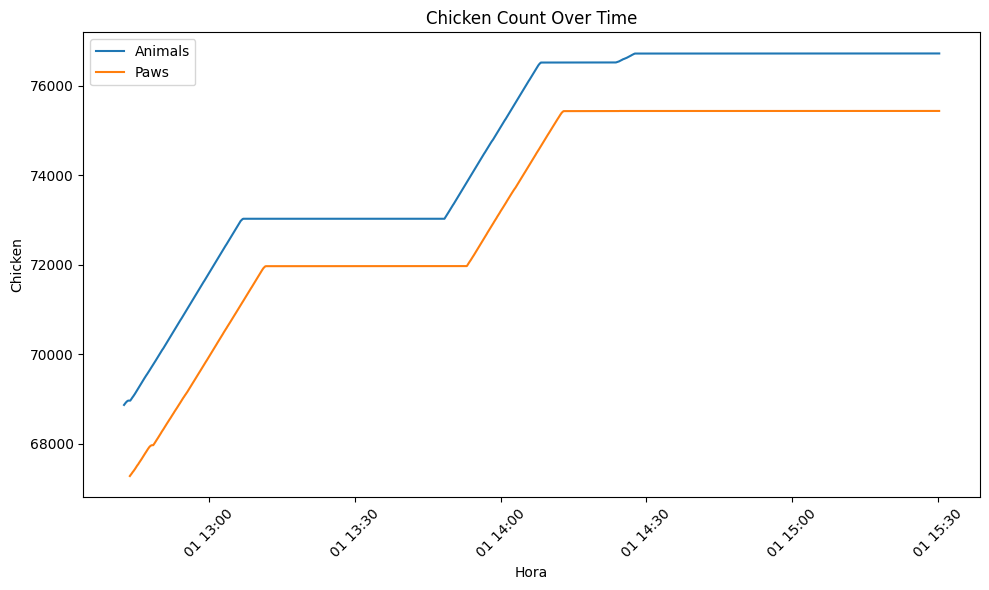

In [6]:

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

date_to_see = datetime(year=2024, month=11, day=5)
df_a, df_p = fetch_last_rows(date_to_see, 10000)


if not df_a.empty and not df_p.empty:
    df_a['hora'] = pd.to_datetime(df_a['hora'], format='%H:%M:%S')
    df_p['hora'] = pd.to_datetime(df_p['hora'], format='%H:%M:%S')
    plt.figure(figsize=(10, 6))
    plt.plot(df_a['hora'], df_a['chicken'])
    plt.plot(df_p['hora'], df_p['chicken'])
    plt.legend(['Animals','Paws'])
    plt.xlabel('Hora')
    plt.ylabel('Chicken')
    plt.title('Chicken Count Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('sem dados na data')
    print(f'df_a is empty = {df_a.empty}')
    print(f'df_p is empty = {df_p.empty}')



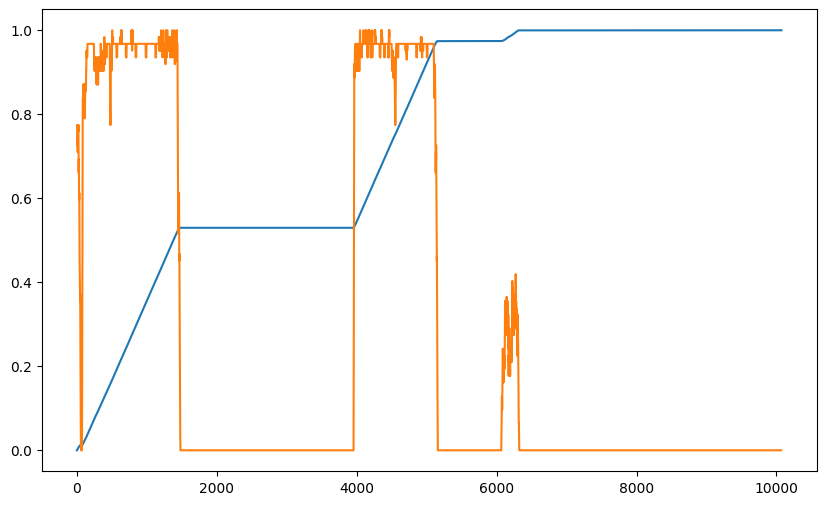

inicio da derivada diferente de zero em i=3775
Frangos totais na entrada: 76516
Frangos que chegaram mortos: 203
Frangos perdidos no processo: 1082


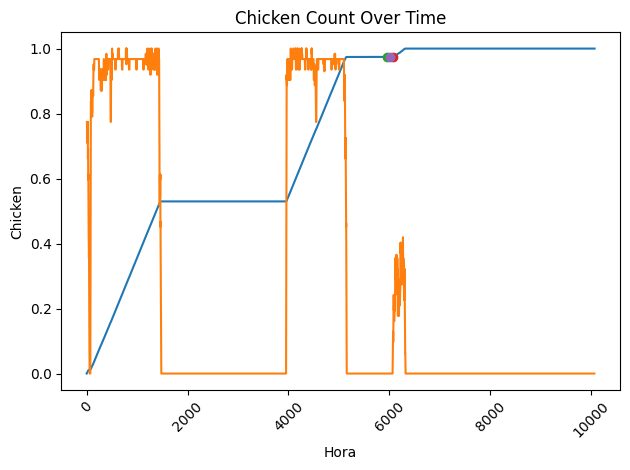

In [7]:


if not df_a.empty and not df_p.empty:
 
   
  comparison = df_p['chicken'] > df_a['chicken']
  if not comparison.any():  

    df = df_a
    
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')
    df['hora_in_seconds'] = (df['hora'] - df['hora'].iloc[0]).dt.total_seconds()

    
    # Ensure 'chicken' and 'hora_in_seconds' are in numeric format
    df['chicken_derivative'] = np.gradient(df['chicken'], df['hora_in_seconds'])
    # Define the window size for moving average (e.g., 5)
    window_size = 10
    # Apply a moving average to smooth the 'chicken_derivative' column
    df['chicken_derivative_smoothed'] = df['chicken_derivative'].rolling(window=window_size, center=True).mean()
    df['chicken_derivative_smoothed'] = df['chicken_derivative_smoothed']/df['chicken_derivative_smoothed'].max()
    reversed_derivative = df['chicken_derivative_smoothed'][::-1]



    plt.figure(figsize=(10, 6))
    plt.plot(df['hora_in_seconds'], (df['chicken']-df['chicken'].iloc[0])/(df['chicken'].iloc[-1]-df['chicken'].iloc[0]))
    plt.plot(df['hora_in_seconds'], df['chicken_derivative_smoothed'])
    plt.show()        

    not_zero  = 0
    for i, value in enumerate(reversed_derivative):
        if value != 0:
            not_zero += 1
            if not_zero > 50:
                break
        else: 
            not_zero = 0

    print(f'inicio da derivada diferente de zero em i={i}')
    # Step 2: Now search for the first interval of 100 consecutive zeros after encountering the first non-zero
    if not_zero:
        # Initialize variables for finding the interval of 100 consecutive zeros
        zero_interval_start = None
        consecutive_zero_count = 0

        for j in range(i, len(reversed_derivative)):
            if reversed_derivative.iloc[j] < 0.1:
                if zero_interval_start is None:
                    zero_interval_start = j                    
                consecutive_zero_count += 1
                
                if consecutive_zero_count == 120:
                    # We've found the first interval of 100 consecutive zeros
                    interval_indices = (zero_interval_start, j)
                    break
            else:
                #print(reversed_derivative.iloc[j])
                # Reset if we encounter a non-zero
                zero_interval_start = None
                consecutive_zero_count = 0
                interval_indices = (0, 0)
    



    start = len(reversed_derivative)-interval_indices[1]
    end = len(reversed_derivative)-interval_indices[0]

    i_total = (start+end) // 2
    
    if i_total == 3600:
        print('problemas com indices')
    else: 
        Frangos_in = df['chicken'].iloc[i_total]
        Frangos_mortos = max(df['chicken'].iloc[-1]-df['chicken'].iloc[i_total],0)
        Frangos_perdidos = max(df['chicken'].iloc[i_total] - df_p['chicken'].iloc[-1],0)

        print(f'Frangos totais na entrada: {Frangos_in}')
        print(f'Frangos que chegaram mortos: {Frangos_mortos}')
        print(f'Frangos perdidos no processo: {Frangos_perdidos}')

        import matplotlib.pyplot as plt
        import matplotlib
        plt.plot(df['hora_in_seconds'], (df['chicken']-df['chicken'].iloc[0])/(df['chicken'].iloc[-1]-df['chicken'].iloc[0]))
        plt.plot(df['hora_in_seconds'], df['chicken_derivative_smoothed'])
        plt.plot(df['hora_in_seconds'].iloc[start], (df['chicken'].iloc[start]-df['chicken'].iloc[0])/(df['chicken'].iloc[-1]-df['chicken'].iloc[0]), marker='o')
        plt.plot(df['hora_in_seconds'].iloc[end], (df['chicken'].iloc[end]-df['chicken'].iloc[0])/(df['chicken'].iloc[-1]-df['chicken'].iloc[0]), marker='o')
        plt.plot(df['hora_in_seconds'].iloc[i_total], (df['chicken'].iloc[i_total]-df['chicken'].iloc[0])/(df['chicken'].iloc[-1]-df['chicken'].iloc[0]), marker='o')
        plt.xlabel('Hora')
        plt.ylabel('Chicken')
        plt.title('Chicken Count Over Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
  else:
      print('Dados inconsistentes')

else:
    print('dados vazios para a data')

In [8]:
print(len(df_a['chicken'].tail(200)), len(df_p['chicken'].tail(200)))
print(df_a['chicken'])
print(df_p['chicken'])

200 200
0       68862
1       68865
2       68868
3       68870
4       68873
        ...  
9995    76719
9996    76719
9997    76719
9998    76719
9999    76719
Name: chicken, Length: 10000, dtype: int64
0       67273
1       67275
2       67278
3       67281
4       67283
        ...  
9995    75434
9996    75434
9997    75434
9998    75434
9999    75434
Name: chicken, Length: 10000, dtype: int64


In [9]:
## same but in a function
import numpy as np
from datetime import datetime
import psycopg2
from psycopg2 import sql
import pandas as pd
from datetime import datetime
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, message='.*pandas only supports SQLAlchemy connectable.*')


def fetch_last_rows(date_to_see, row_limit=60*60):
    try:
        conn = psycopg2.connect(database="mytestdb",
            user="postgres",
            host='localhost',
            password="theia@24",
            port=5432)
        
        query = f"SELECT hora, chicken FROM paws WHERE data = '{date_to_see}' ORDER BY hora ASC"
        df_p = pd.read_sql_query(query, conn)
        query = f"SELECT hora, chicken FROM animals WHERE data = '{date_to_see}' ORDER BY hora ASC"
        df_a = pd.read_sql_query(query, conn)
        
        return df_a.tail(row_limit), df_p.tail(row_limit)

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

    finally:
        #cur.close()
        conn.close()


def compute_loss(date):    
    df_a, df_p = fetch_last_rows(date, 4000)
    if not df_a.empty and not df_p.empty:
        df_a = df_a.drop_duplicates(subset='hora', keep='first')
        df_p = df_p.drop_duplicates(subset='hora', keep='first')
        df = df_a
        
        df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')
        df['hora_in_seconds'] = (df['hora'] - df['hora'].iloc[0]).dt.total_seconds()

        
        # Ensure 'chicken' and 'hora_in_seconds' are in numeric format
        df['chicken_derivative'] = np.gradient(df['chicken'], df['hora_in_seconds'])
        # Define the window size for moving average (e.g., 5)
        window_size = 10
        # Apply a moving average to smooth the 'chicken_derivative' column
        df['chicken_derivative_smoothed'] = df['chicken_derivative'].rolling(window=window_size, center=True).mean()
        df['chicken_derivative_smoothed'] = df['chicken_derivative_smoothed']/df['chicken_derivative_smoothed'].max()
        reversed_derivative = df['chicken_derivative_smoothed'][::-1]
        
        not_zero  = 0
        for i, value in enumerate(reversed_derivative):
            if value != 0:
                not_zero += 1
                if not_zero > 50:
                    break
            else: 
                not_zero = 0

        print(f'\n(Compute loss):\nInicio da derivada diferente de zero em i={i}')
        # Step 2: Now search for the first interval of 100 consecutive zeros after encountering the first non-zero
        if not_zero:
            # Initialize variables for finding the interval of 100 consecutive zeros
            zero_interval_start = None
            consecutive_zero_count = 0

            for j in range(i, len(reversed_derivative)):
                if reversed_derivative.iloc[j] < 0.1:
                    if zero_interval_start is None:
                        zero_interval_start = j                    
                    consecutive_zero_count += 1
                    
                    if consecutive_zero_count == 120:
                        # We've found the first interval of 100 consecutive zeros
                        interval_indices = (zero_interval_start, j)
                        break
                else:
                    #print(reversed_derivative.iloc[j])
                    # Reset if we encounter a non-zero
                    zero_interval_start = None
                    consecutive_zero_count = 0
                    interval_indices = (0, 0)
        



        start = len(reversed_derivative)-interval_indices[1]
        end = len(reversed_derivative)-interval_indices[0]

        i_total = (start+end) // 2
        
        if i_total == 3600:
            print('problemas com indices')
        else: 
            Frangos_vivos = df['chicken'].iloc[i_total]
            Frangos_mortos = max(df['chicken'].iloc[-1]-df['chicken'].iloc[i_total],0)
            Frangos_perdidos = max(df['chicken'].iloc[i_total] - df_p['chicken'].iloc[-1],0)
    else:
        Frangos_vivos=0
        Frangos_mortos=0
        Frangos_perdidos=0
        print('Sem dados para calcular as perdas')
    
    return Frangos_mortos, Frangos_perdidos

date_to_see = datetime(year=2024, month=9, day=20)

print(compute_loss(date_to_see))
Fmortos,Fperdidos=compute_loss(date_to_see)

print(Fmortos,Fperdidos)
# Sample DataFrame
data = {
    'date': ['2024-10-08', '2024-10-09', '2024-10-11']
}
aggregated_df = pd.DataFrame(data)
aggregated_df[['Frangos Perdidos', 'Frangos Mortos']] = aggregated_df['date'].apply(lambda date: pd.Series(compute_loss(date)))
print(aggregated_df)

Sem dados para calcular as perdas
(0, 0)
Sem dados para calcular as perdas
0 0

(Compute loss):
Inicio da derivada diferente de zero em i=2438
Sem dados para calcular as perdas

(Compute loss):
Inicio da derivada diferente de zero em i=1869
         date  Frangos Perdidos  Frangos Mortos
0  2024-10-08               179            2090
1  2024-10-09                 0               0
2  2024-10-11               179           27031
